# VGG19

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /content
%rm -r "/content/data_splitted_final"
%rm -r "/content/training_data_final"
%rm -r "/content/model"

/content
rm: cannot remove '/content/data_splitted_final': No such file or directory
rm: cannot remove '/content/training_data_final': No such file or directory
rm: cannot remove '/content/model': No such file or directory


In [ ]:
%cd /gdrive/My Drive

# PREPROCESSING

### IMPORT

In [4]:
#import of all necessary libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg19

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Activation, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop
from matplotlib import pyplot as plt
from keras.callbacks import CSVLogger
from keras.models import model_from_json
import tensorflow as tf
import numpy as np
import math 
from PIL import Image
from keras.models import model_from_json
import os
import time 
import sys 

from keras.applications.vgg19 import preprocess_input

tfk = tf.keras
tfkl = tf.keras.layers


# set the Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#REMOVE ALL WARNINGS
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Split the original folder

In [ ]:
!pip install split-folders

In [ ]:
!unzip "/content/training_data_final.zip" -d "/content"

In [ ]:
#specify the input folder where the functions takes the data, and the new folder
import splitfolders  
input_folder = '/content/training_data_final'
output_folder='/content/data_splitted_final'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None)


### READ IMAGES AND SET LABELS

In [ ]:
#Already did that
#!unzip "/content/data_splitted_final.zip" -d "/content"

In [ ]:
#TO CHECK DIRECTORY CORRECTLY UNZIPPED FILES
os.chdir("/content/training_data_final")

In [ ]:
#TO CHECK IF DATASET IS SPLIT IN TRAIN AND VALIDATION
!ls

Species1  Species2  Species3  Species4	Species5  Species6  Species7  Species8


In [ ]:
dataset_dir = "/content/data_splitted_final"

In [ ]:
os.chdir("/content/data_splitted_final")

In [ ]:
!ls

In [ ]:
#Write the labels, they need to the same as the name of the folders
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8'] #7

TypeError: ignored

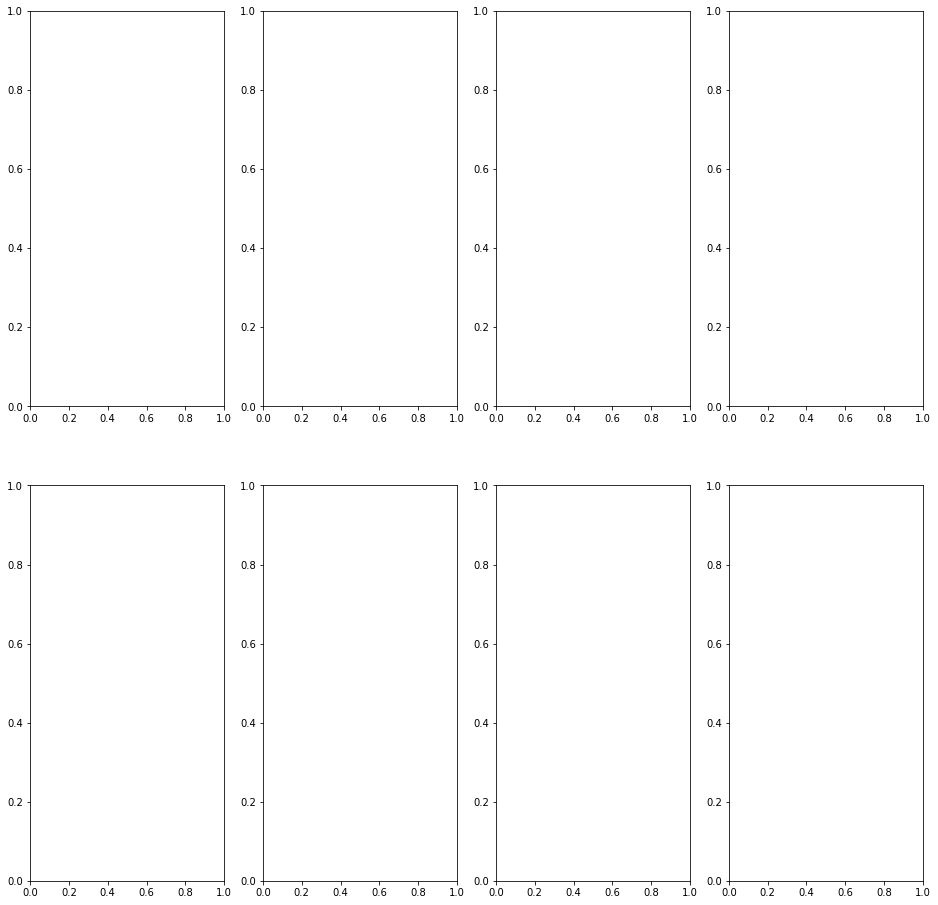

In [ ]:
#This snippet of code is used just to plot the images as an example, in order to inspect them    
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,4*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [ ]:
#WRITE THE PATHS WHERE THE IMAGES ARE GOING TO BE TAKEN FROM
training_dir = "/content/data_splitted_final/train"
validation_dir = "/content/data_splitted_final/val"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(height_shift_range=0.45,
                                        width_shift_range=0.45,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function = preprocess_input,) 

valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size= (96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=16,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size= (96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


# LEARN

### MODEL METADATA

In [ ]:
input_shape = (144, 144, 3)
epochs = 100

### CNN MODEL: TRANSFER LEARNING PART

In [ ]:
#DOWNLOAD THE PRETRAINED VGG19. SET ALL LAYERS TO NON TRAINABLE
vgg_conv = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(144, 144, 3))
for layer in vgg_conv.layers:
    layer.trainable = False
vgg_conv.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 144, 144, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 144, 144, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 144, 144, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 72, 72, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 72, 72, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 72, 72, 128)       147584    
                                                              

In [ ]:
#THE ACTUAL MODEL: INPUT + RESIZING TO FIT THE IMAGE IN THE PRETRAINED MODEL + VGG19 + GLOBALAVERAGEPOOLING2D + DENSE LAYERS
inputs = tfkl.Input(shape=(96,96,3))
x = tfkl.Resizing(144,144, interpolation="nearest", crop_to_aspect_ratio = False)(inputs)
x = vgg_conv(x)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.1, seed=seed)(x)
x = tfkl.Dense(1024, activation = 'relu')(x)
x = tfkl.Dense(512, activation = 'relu')(x)
x = tfkl.LeakyReLU(alpha=0.1)(x)
output_layer = tfkl.Dense(
        units = 8, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

model = tfk.Model(inputs = inputs, outputs = output_layer, name = 'model')

labels, batchSize, totalEpochs, learningRate, dropout, key = 8, 64, 20, 0.01, 0.5, "SGD"
weightDecay = learningRate/totalEpochs

optim = tfk.optimizers.Adam()

model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

model.summary()

NameError: ignored

In [ ]:
# Train the model: 100 epochs 
checkpoint = tfk.callbacks.ModelCheckpoint("/content/model/", monitor='val_acc', verbose=1, save_best_only=True, mode='auto', save_weights_only = True)
reduceLROnPlat = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = tfk.callbacks.EarlyStopping(monitor="'val_acc'", mode="auto", patience=30) 

callbacks_list = [checkpoint, early, reduceLROnPlat]

history = model.fit(
    x = aug_train_gen,
    epochs = 100,
    validation_data = valid_gen,
    callbacks = callbacks_list 
).history

Epoch 1/100
177/177 [==============================] - 13s 71ms/step - loss: 1.7343 - accuracy: 0.4517 - val_loss: 1.2693 - val_accuracy: 0.5316 - lr: 0.0010
Epoch 2/100
177/177 [==============================] - 12s 69ms/step - loss: 1.2836 - accuracy: 0.5175 - val_loss: 1.2014 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 3/100
177/177 [==============================] - 13s 73ms/step - loss: 1.2219 - accuracy: 0.5574 - val_loss: 1.1824 - val_accuracy: 0.5792 - lr: 0.0010
Epoch 4/100
177/177 [==============================] - 12s 68ms/step - loss: 1.1771 - accuracy: 0.5596 - val_loss: 1.2356 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 5/100
177/177 [==============================] - 12s 69ms/step - loss: 1.1391 - accuracy: 0.5737 - val_loss: 1.1702 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 6/100
177/177 [==============================] - 12s 69ms/step - loss: 1.1252 - accuracy: 0.5790 - val_loss: 1.1121 - val_accuracy: 0.5792 - lr: 0.0010
Epoch 7/100
177/177 [==============================]

### Plot the training

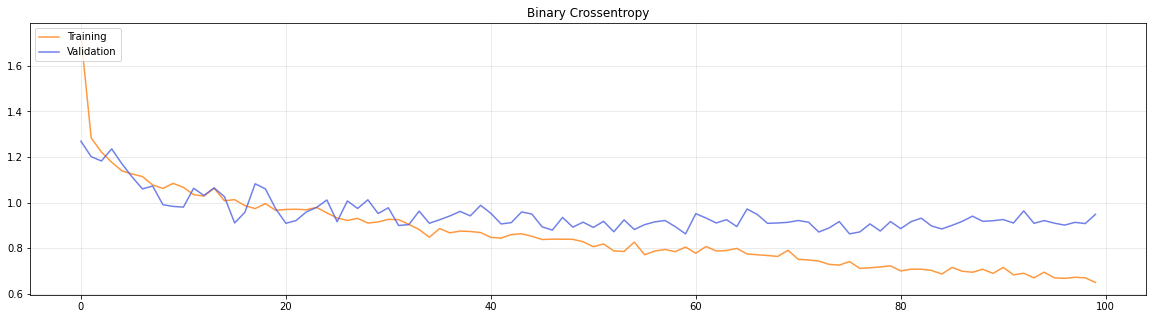

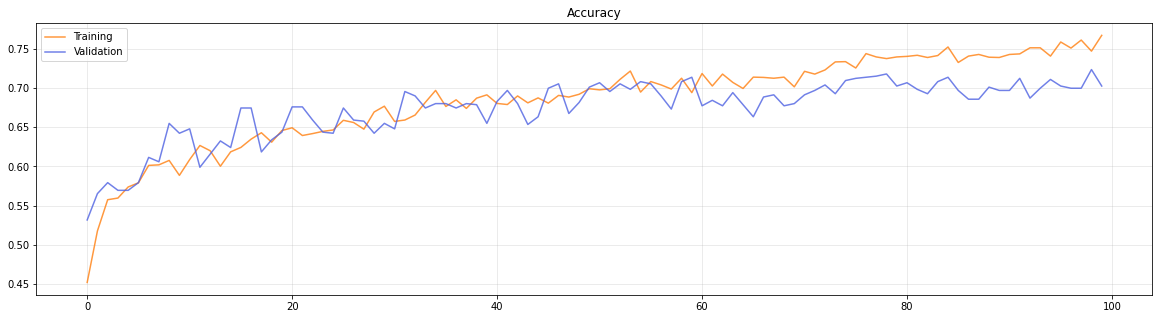

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Show Statistics

### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('/content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS/vgg19')

In [ ]:
%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS

In [ ]:
model.save('/content/vgg19')

### Fine Tuning

In [ ]:
#LOAD THE MODEL
ft_model = tfk.models.load_model('/content/vgg19')

In [ ]:
#load from drive
#%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS
#ft_model= tfk.models.load_model('vgg19')

In [ ]:
ft_model.summary()

In [ ]:
# Set all exception layers to True
ft_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

ft_model.summary()

In [ ]:
#UNFREEZE SOME LAYERS
for i, layer in enumerate(ft_model.get_layer('vgg19').layers[:14]):
  layer.trainable=False
#SEE THE LAYERS THAT ARE FREEZE AND THOSE WHO ARE NOT
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing_2 (Resizing)       (None, 144, 144, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 

In [ ]:
# Compile the model: THIS TIME THE LEARNING RATE IS SMALLER TO DO THE FINE TUNING
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')


In [ ]:
history = ft_model.fit(
    x = aug_train_gen,
    epochs = 150,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)] #,    class_weight= class_weights
).history

Epoch 1/150
177/177 [==============================] - 16s 87ms/step - loss: 1.5026 - accuracy: 0.4542 - val_loss: 1.2152 - val_accuracy: 0.5217
Epoch 2/150
177/177 [==============================] - 15s 86ms/step - loss: 1.2264 - accuracy: 0.5461 - val_loss: 1.1166 - val_accuracy: 0.6003
Epoch 3/150
177/177 [==============================] - 15s 85ms/step - loss: 1.0823 - accuracy: 0.6105 - val_loss: 0.9399 - val_accuracy: 0.6592
Epoch 4/150
177/177 [==============================] - 15s 84ms/step - loss: 1.0084 - accuracy: 0.6345 - val_loss: 0.8147 - val_accuracy: 0.7139
Epoch 5/150
177/177 [==============================] - 15s 84ms/step - loss: 0.9214 - accuracy: 0.6787 - val_loss: 0.8626 - val_accuracy: 0.6564
Epoch 6/150
177/177 [==============================] - 15s 85ms/step - loss: 0.8664 - accuracy: 0.6974 - val_loss: 0.9482 - val_accuracy: 0.6816
Epoch 7/150
177/177 [==============================] - 15s 85ms/step - loss: 0.8278 - accuracy: 0.7109 - val_loss: 0.8665 - val_ac

In [ ]:
#to save model on Drive
#ft_model.save('/content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS/vgg19')

In [ ]:
ft_model.save('/content/vgg19')

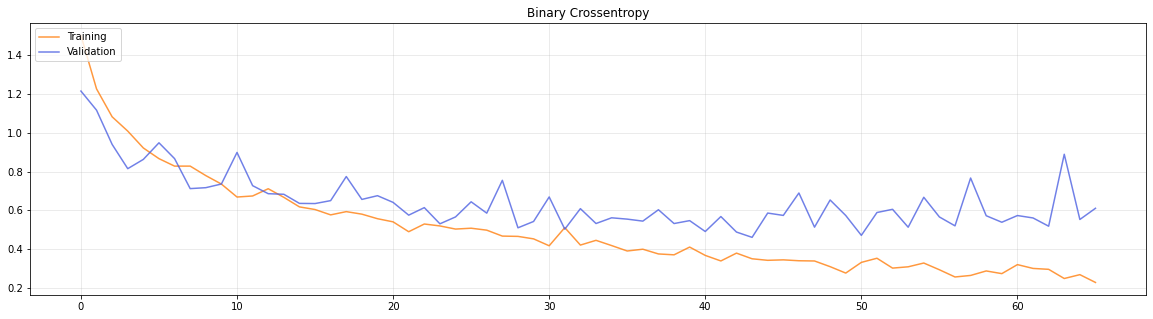

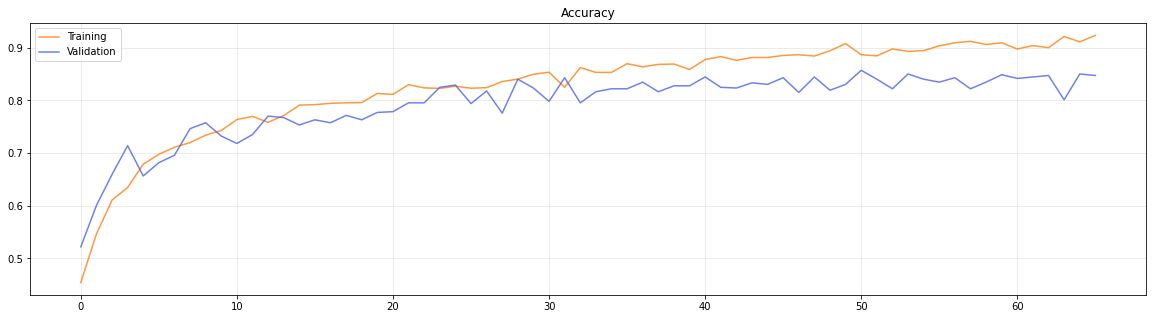

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# XCEPTION

# PREPROCESSING

### IMPORT




In [ ]:
#import the necessary libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from keras.applications.xception import preprocess_input

tfk = tf.keras
tfkl = tf.keras.layers


# set the Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#REMOVE ALL WARNINGS
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### READ IMAGES AND SET LABELS

In [ ]:
#already unzipped
#!unzip "/content/data_splitted_final.zip" -d "/content"

In [ ]:
#TO CHECK DIRECTORY CORRECTLY UNZIPPED FILES
os.chdir("/content/data_splitted_final")

In [ ]:
#TO CHECK IF DATASET IS SPLIT IN TRAIN AND VALIDATION
!ls

train  val


In [ ]:
dataset_dir = "/content/data_splitted_final"

In [ ]:
#Write the labels, they need to the same as the name of the folders
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8'] #7

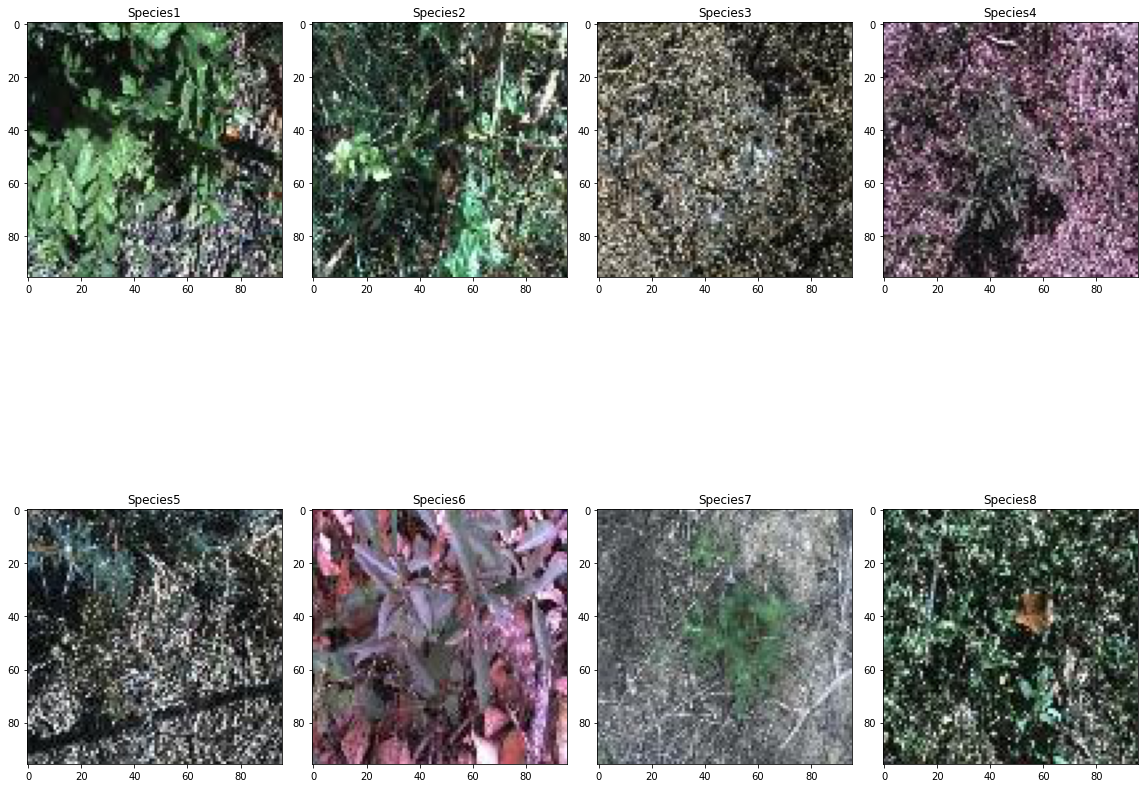

In [ ]:
#This snippet of code is used just to plot the images as an example, in order to inspect them    
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,4*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [ ]:
#WRITE THE PATHS WHERE THE IMAGES ARE GOING TO BE TAKEN FROM
training_dir = "/content/data_splitted_final/train"
validation_dir = "/content/data_splitted_final/val"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=35, #ROTATES THE IMAGE AT MOST THAT DEGREES
                                        height_shift_range=0.35, #SHIFTS THE IMAGE AT MOST 35% OF ITS HEIGHT
                                        width_shift_range=0.35, #SHIFTS THE IMAGE AT MOST 35% OF ITS WIDTH
                                        zoom_range=0.20, #ZOOMS AT MOST 20% 
                                        brightness_range = (0.75,1.25), #CHANGES THE BRIGHTNESS
                                        shear_range = 0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function= preprocess_input) 

valid_data_gen = ImageDataGenerator(preprocessing_function= preprocess_input)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None,
                                                           class_mode='categorical',
                                                           batch_size=16,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


# LEARN

### MODEL METADATA

In [ ]:
input_shape = (150, 150, 3)
epochs = 100

### CNN MODEL: TRANSFER LEARNING PART



In [ ]:
#DOWNLOAD THE PRETRAINED XCEPTION. SET ALL LAYERS TO NON TRAINABLE
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape= (150,150,3))
for layer in xception.layers:
  layer.trainable = False
xception.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [ ]:
#THE ACTUAL MODEL: INPUT + RESIZING TO FIT THE IMAGE IN THE PRETRAINED MODEL + XCEPTION + FLATTEN + TWO DENSE LAYERS

inputs = tfk.Input(shape=(96,96,3))

x= tfkl.Resizing(150,150,interpolation="nearest", crop_to_aspect_ratio=False)(inputs)

x = xception(x)

x = tfkl.Flatten(name='Flattening')(x)

x = tfkl.Dropout(0.25, seed=seed)(x)

x = tfkl.Dense(
    32, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)

x = tfkl.Dropout(0.25, seed=seed)(x)

outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)



tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

In [ ]:
#IN ORDER TO REDUCE THE IMPACT OF THE FACT THAT THE DATASET IS SLIGHTY IMBALANCED
class_weights = {0: 1. ,1: 2.86 ,2: 2.77 ,3: 2.75 ,4: 2.85 ,5: 1.19 ,6: 2.89 ,7: 2.73 }

In [ ]:
# Train the model: 100 epochs with early stopping
history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
    class_weight = class_weights
).history

Epoch 1/100
177/177 [==============================] - 27s 91ms/step - loss: 4.8084 - accuracy: 0.3054 - val_loss: 1.5701 - val_accuracy: 0.4278
Epoch 2/100
177/177 [==============================] - 16s 93ms/step - loss: 4.3772 - accuracy: 0.3337 - val_loss: 1.5178 - val_accuracy: 0.4180
Epoch 3/100
177/177 [==============================] - 17s 94ms/step - loss: 4.1130 - accuracy: 0.3595 - val_loss: 1.4474 - val_accuracy: 0.4727
Epoch 4/100
177/177 [==============================] - 18s 102ms/step - loss: 4.0023 - accuracy: 0.3786 - val_loss: 1.4161 - val_accuracy: 0.4937
Epoch 5/100
177/177 [==============================] - 15s 84ms/step - loss: 3.8780 - accuracy: 0.3987 - val_loss: 1.4184 - val_accuracy: 0.4867
Epoch 6/100
177/177 [==============================] - 16s 92ms/step - loss: 3.8631 - accuracy: 0.3998 - val_loss: 1.3832 - val_accuracy: 0.5203
Epoch 7/100
177/177 [==============================] - 16s 93ms/step - loss: 3.8802 - accuracy: 0.4001 - val_loss: 1.3878 - val_a

### Plot the training

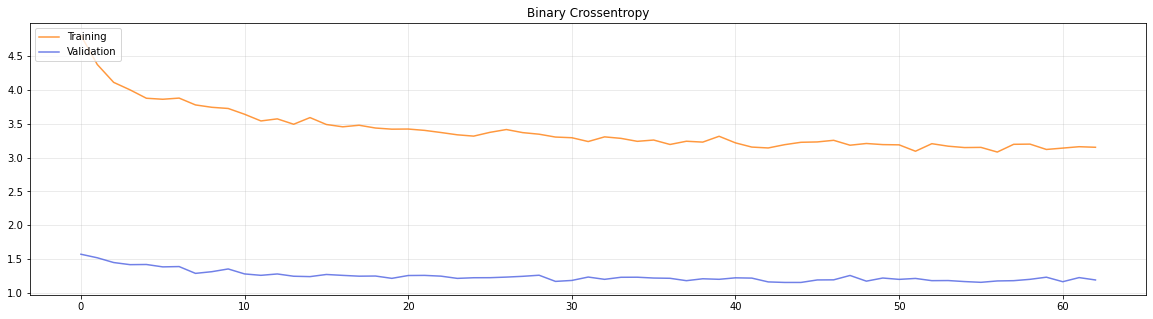

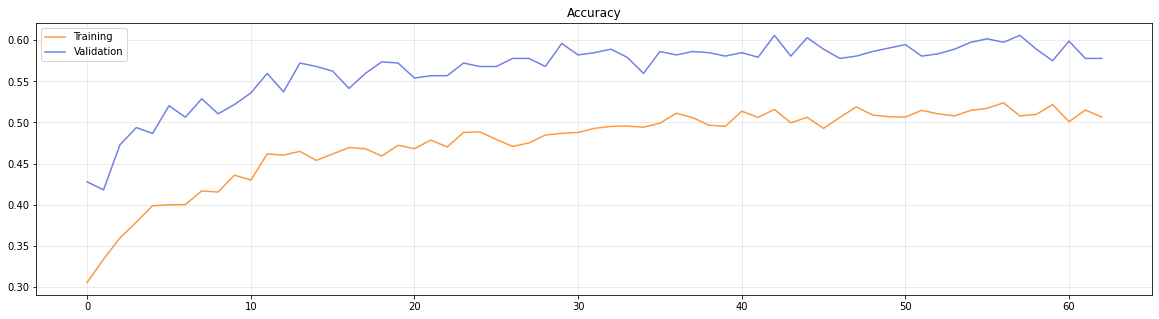

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Show Statistics

### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tl_model.save('/content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS/xception')

In [ ]:
%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS

/content/drive/MyDrive/A2NDL


In [ ]:
tl_model.save('/content/xception')

### Fine Tuning

In [ ]:
#LOAD THE MODEL
ft_model = tfk.models.load_model('/content/xception')

In [ ]:
#load from drive
#%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS
#ft_model= tfk.models.load_model('xception')

In [ ]:
ft_model.summary()

In [ ]:
# Set all exception layers to True
ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

ft_model.summary()

In [ ]:
#UNFREEZE SOME LAYERS
for i, layer in enumerate(ft_model.get_layer('xception').layers[:60]):
  layer.trainable=False
#SEE THE LAYERS THAT ARE FREEZE AND THOSE WHO ARE NOT
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
# Compile the model: THIS TIME THE LEARNING RATE IS SMALLER TO DO THE FINE TUNING
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
history = ft_model.fit(
    x = aug_train_gen,
    epochs = 120,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True)],
    class_weight = class_weights
).history

Epoch 1/120
177/177 [==============================] - 24s 105ms/step - loss: 3.7937 - accuracy: 0.4288 - val_loss: 1.3426 - val_accuracy: 0.5722
Epoch 2/120
177/177 [==============================] - 16s 91ms/step - loss: 3.2451 - accuracy: 0.5023 - val_loss: 1.0876 - val_accuracy: 0.6185
Epoch 3/120
177/177 [==============================] - 16s 90ms/step - loss: 3.0573 - accuracy: 0.5338 - val_loss: 1.1099 - val_accuracy: 0.6213
Epoch 4/120
177/177 [==============================] - 17s 98ms/step - loss: 2.8690 - accuracy: 0.5596 - val_loss: 1.0859 - val_accuracy: 0.6396
Epoch 5/120
177/177 [==============================] - 16s 90ms/step - loss: 2.8083 - accuracy: 0.5723 - val_loss: 0.9752 - val_accuracy: 0.6816
Epoch 6/120
177/177 [==============================] - 16s 90ms/step - loss: 2.6812 - accuracy: 0.5942 - val_loss: 1.0580 - val_accuracy: 0.6676
Epoch 7/120
177/177 [==============================] - 16s 91ms/step - loss: 2.5288 - accuracy: 0.6172 - val_loss: 0.9438 - val_a

In [ ]:
#save on drive
#ft_model.save('/content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS/xception')

In [ ]:
ft_model.save('/content/xception')

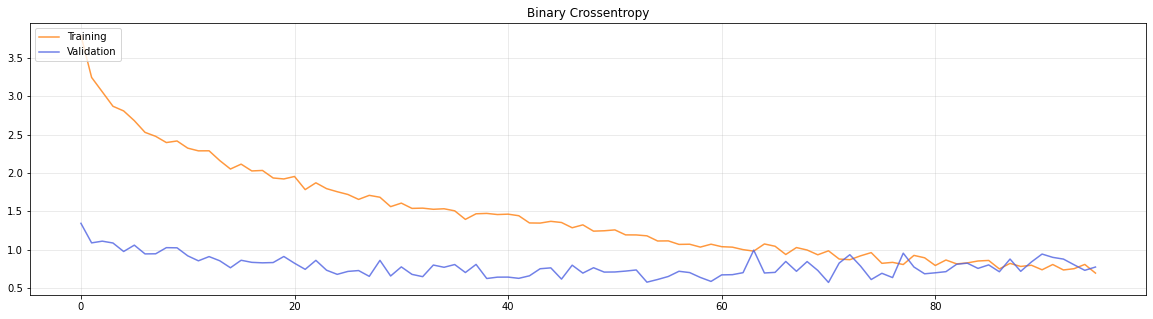

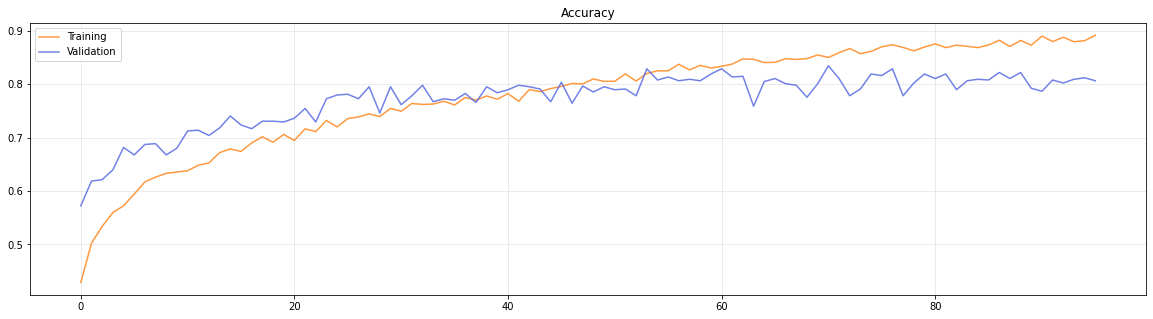

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# RESNET50V2

# PREPROCESSING

### IMPORT




In [ ]:
#import of all necessary libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from keras.applications.resnet_v2 import preprocess_input



tfk = tf.keras
tfkl = tf.keras.layers


# set the Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#REMOVE ALL WARNINGS
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### READ IMAGES AND SET LABELS

In [ ]:
#UNZIP THE DATASET, ALREADY PREVIOUSLY SPLIT, already unzipped
#!unzip "/content/data_splitted_final.zip" -d "/content"

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/data_splitted_final/train/Species6/00146.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00146.jpg  
  inflating: /content/data_splitted_final/train/Species6/00152.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00152.jpg  
  inflating: /content/data_splitted_final/train/Species6/00185.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00185.jpg  
  inflating: /content/data_splitted_final/train/Species6/00191.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00191.jpg  
  inflating: /content/data_splitted_final/train/Species6/00032.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00032.jpg  
  inflating: /content/data_splitted_final/train/Species6/00027.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00027.jpg  
  inflating: /content/data_splitted_final/train/Species6

In [ ]:
#TO CHECK
os.chdir("/content/data_splitted_final")

In [ ]:
!ls

train  val


In [ ]:
#DIRECTORY OF THE DATASET
dataset_dir = "/content/data_splitted_final"

In [ ]:
#Write the labels, they need to the same as the name of the folders
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8'] #7

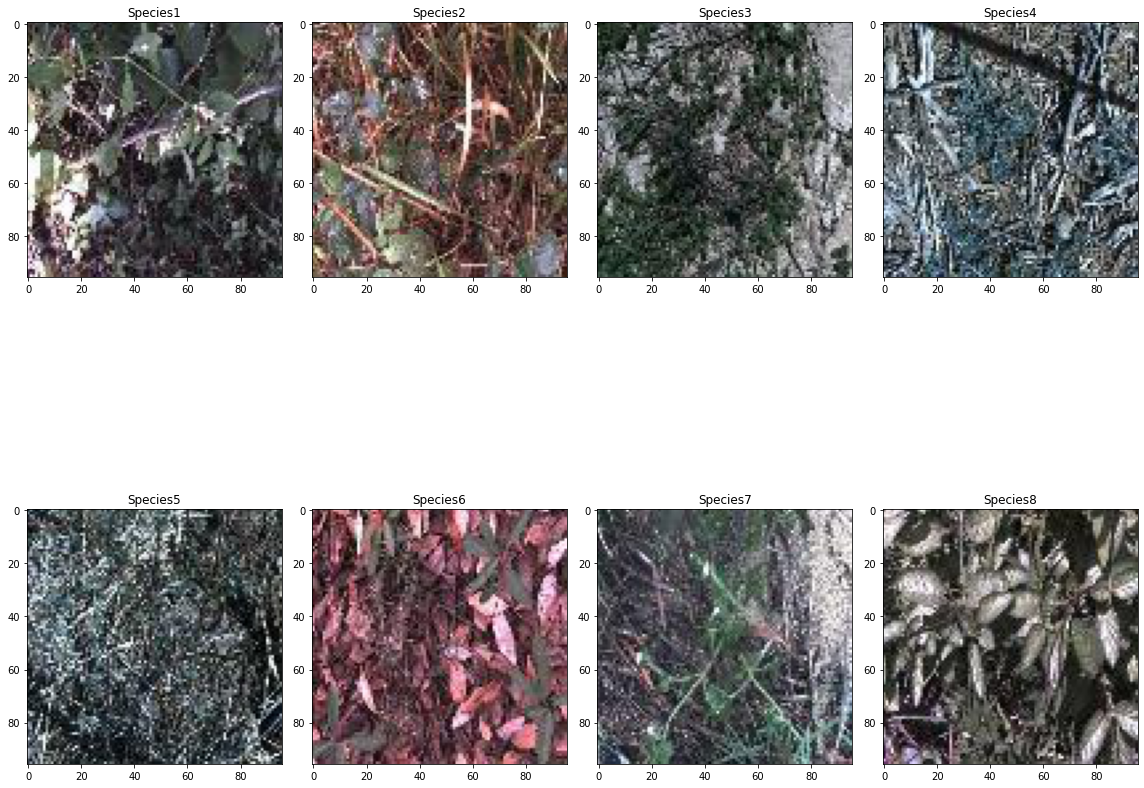

In [ ]:
#This snippet of code is used just to plot the images as an example, in order to inspect them    
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,4*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/val/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/val/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [ ]:
#DIRECTORY OF BOTH TRAINING AND VALIDATION SET
training_dir = "/content/data_splitted_final/train"
validation_dir = "/content/data_splitted_final/val"

parmeters that have to be changed everytime according to model structure

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#DATA AUGMENTATION: ROTATION,SHIFT,ZOOM,BRIGHTNESS,FLIPS,PREPROCESSING TYPICAL OF RESNET

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=35,
                                        height_shift_range=0.33,
                                        width_shift_range=0.33,
                                        zoom_range=0.25,
                                        brightness_range = (0.8,1.2),
                                        shear_range = 0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function = preprocess_input
                                        ) # rescale value is multiplied to the image

valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size= (96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=32,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size= (224,224),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


# LEARN

### MODEL METADATA

In [ ]:
#METADETA
input_shape = (224, 224, 3)
epochs = 100

### CNN MODEL

In [ ]:
#DOWNLOAD THE RESNET50V2: USE WEIGHTS OF IMAGENET ALSO SET ALL THE LAYERS TO FALSE
resnet50 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape = (224,224,3))
for layer in resnet50.layers:
  layer.trainable = False
resnet50.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
#MODEL: INPUT + RESIZING + RESNET50V2 + THREE DENSE LAYERS(WITH RIDGE REGRESSION)
inputs = tfk.Input(shape=(96,96,3))

x= tfkl.Resizing(224,224,interpolation="nearest", crop_to_aspect_ratio=False)(inputs)

x = resnet50(x)
x = tfkl.Flatten(name='Flattening')(x)

x = tfkl.Dense(
    64, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    )(x)

x= tfkl.Dropout(0.15, seed=seed)(x)

x = tfkl.Dense(
    32, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    )(x)

x= tfkl.Dropout(0.15, seed=seed)(x)

outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(x)


resnet50 = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
resnet50.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 Flattening (Flatten)        (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080  

In [ ]:
#TO OVERCOME THE PROBLEMS DUE TO SLIGHTLY IMBALANCED DATASET
class_weights = {0: 1. ,1: 2.86 ,2: 2.77 ,3: 2.75 ,4: 2.85 ,5: 1.19 ,6: 2.89 ,7: 2.73 }

In [ ]:
# Train the model: FOR 100 EPOCHS AND WITH EARLY STOPPING
history = resnet50.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)],
    class_weight = class_weights
).history

Epoch 1/100
89/89 [==============================] - 26s 169ms/step - loss: 6.4162 - accuracy: 0.2340 - val_loss: 1.8040 - val_accuracy: 0.3212
Epoch 2/100
89/89 [==============================] - 16s 179ms/step - loss: 4.7815 - accuracy: 0.2881 - val_loss: 1.6632 - val_accuracy: 0.3857
Epoch 3/100
89/89 [==============================] - 16s 177ms/step - loss: 4.5099 - accuracy: 0.2959 - val_loss: 1.6423 - val_accuracy: 0.3492
Epoch 4/100
89/89 [==============================] - 14s 152ms/step - loss: 4.3802 - accuracy: 0.3100 - val_loss: 1.6174 - val_accuracy: 0.3689
Epoch 5/100
89/89 [==============================] - 13s 149ms/step - loss: 4.4832 - accuracy: 0.3089 - val_loss: 1.6840 - val_accuracy: 0.3871
Epoch 6/100
89/89 [==============================] - 13s 151ms/step - loss: 4.2551 - accuracy: 0.3443 - val_loss: 1.6295 - val_accuracy: 0.4418
Epoch 7/100
89/89 [==============================] - 14s 157ms/step - loss: 4.1705 - accuracy: 0.3726 - val_loss: 1.6351 - val_accuracy:

### Plot the training

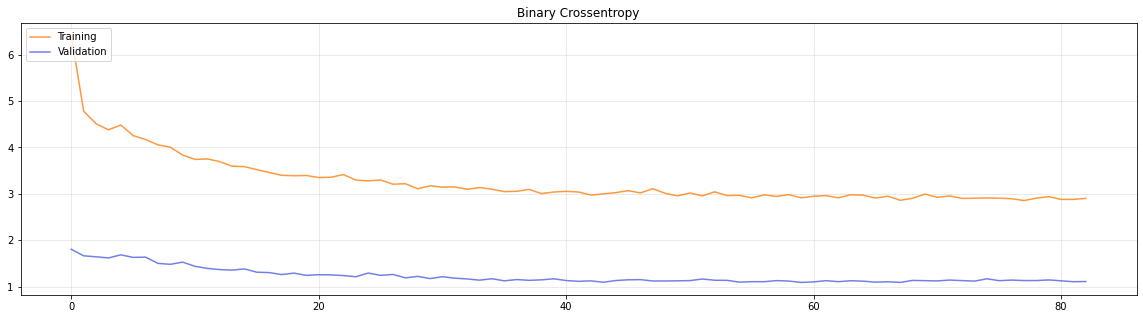

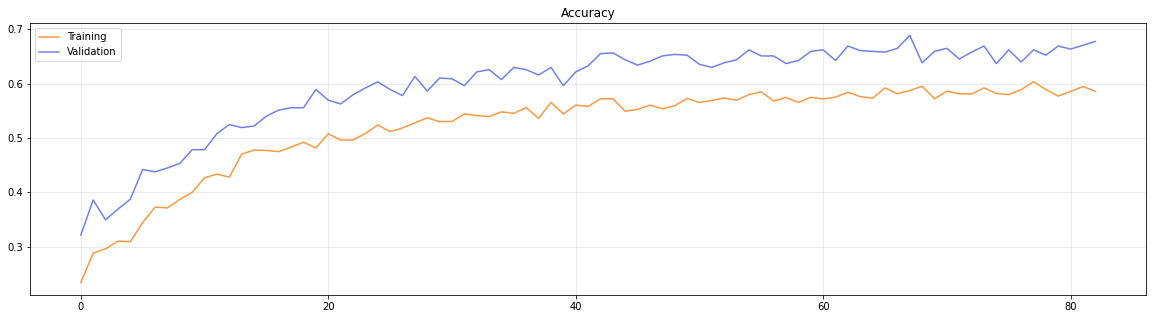

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Show Statistics

### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
resnet50.save('/content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS/resnet50')

In [ ]:
%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS

/content/drive/MyDrive/Final


In [ ]:
resnet50.save('/content/resnet50')

### Fine Tuning

In [ ]:
ft_model = tfk.models.load_model('/content/resnet50')

In [ ]:
#load from drive
#%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS
#ft_model = tfk.models.load_model('resnet50')

In [ ]:
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 Flattening (Flatten)        (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080  

In [ ]:
# Set all resnet layers to True
ft_model.get_layer('resnet50v2').trainable = True
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
   print(i, layer.name, layer.trainable)

ft_model.summary()

0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 pool1_pad True
4 pool1_pool True
5 conv2_block1_preact_bn True
6 conv2_block1_preact_relu True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_pad True
11 conv2_block1_2_conv True
12 conv2_block1_2_bn True
13 conv2_block1_2_relu True
14 conv2_block1_0_conv True
15 conv2_block1_3_conv True
16 conv2_block1_out True
17 conv2_block2_preact_bn True
18 conv2_block2_preact_relu True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37 max_pooling2d True

In [ ]:
#UNFREEZE LAYERS
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers[:150]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
history = ft_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
    class_weight = class_weights
).history

Epoch 1/100
89/89 [==============================] - 21s 185ms/step - loss: 3.5148 - accuracy: 0.4981 - val_loss: 1.1657 - val_accuracy: 0.6269
Epoch 2/100
89/89 [==============================] - 15s 164ms/step - loss: 3.1237 - accuracy: 0.5511 - val_loss: 1.2452 - val_accuracy: 0.6003
Epoch 3/100
89/89 [==============================] - 14s 161ms/step - loss: 2.9440 - accuracy: 0.5797 - val_loss: 1.0308 - val_accuracy: 0.6985
Epoch 4/100
89/89 [==============================] - 14s 161ms/step - loss: 2.7444 - accuracy: 0.6041 - val_loss: 1.0274 - val_accuracy: 0.7013
Epoch 5/100
89/89 [==============================] - 14s 162ms/step - loss: 2.6752 - accuracy: 0.6136 - val_loss: 1.0345 - val_accuracy: 0.6928
Epoch 6/100
89/89 [==============================] - 15s 165ms/step - loss: 2.5834 - accuracy: 0.6317 - val_loss: 0.9808 - val_accuracy: 0.7251
Epoch 7/100
89/89 [==============================] - 14s 159ms/step - loss: 2.5591 - accuracy: 0.6462 - val_loss: 0.9378 - val_accuracy:

In [ ]:
ft_model.save('/content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS/resnet50')

In [ ]:
ft_model.save('/content/resnet50')

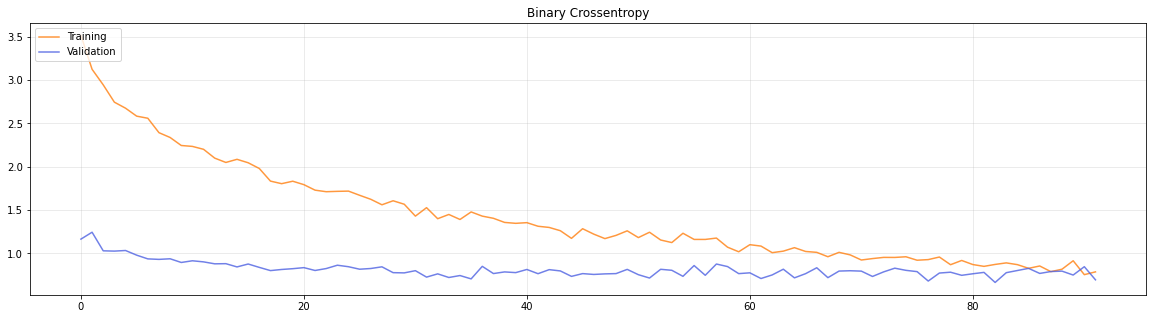

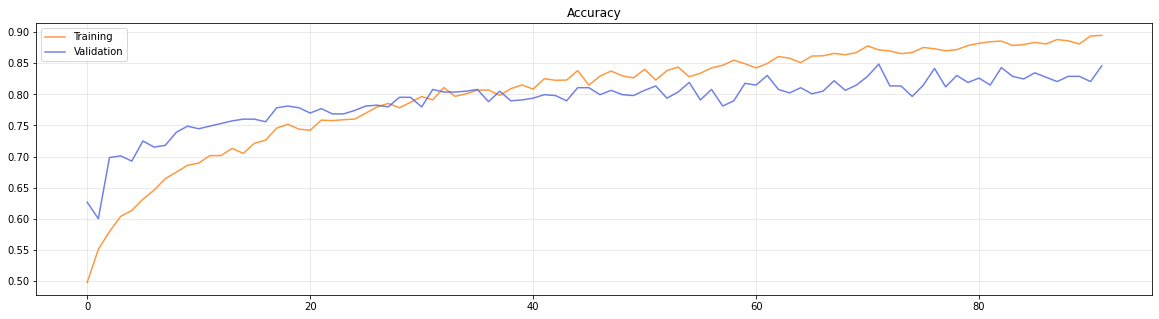

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# EfficientNetB1

# PREPROCESSING

### IMPORT




In [ ]:
#import of all necessary libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.layers.experimental import preprocessing


tfk = tf.keras
tfkl = tf.keras.layers


# set the Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#REMOVE ALL WARNINGS
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### READ IMAGES AND SET LABELS

In [ ]:
#USE THE UNZIP THE DATASET THAT WAS PREVIOUSLY SPLIT IN TRAIN AND VAL. Already unzipped
#!unzip "/content/data_splitted_final.zip" -d "/content"

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/data_splitted_final/train/Species6/00146.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00146.jpg  
  inflating: /content/data_splitted_final/train/Species6/00152.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00152.jpg  
  inflating: /content/data_splitted_final/train/Species6/00185.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00185.jpg  
  inflating: /content/data_splitted_final/train/Species6/00191.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00191.jpg  
  inflating: /content/data_splitted_final/train/Species6/00032.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00032.jpg  
  inflating: /content/data_splitted_final/train/Species6/00027.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00027.jpg  
  inflating: /content/data_splitted_final/train/Species6

In [ ]:
#TO GET DIRECTORY
os.chdir("/content/data_splitted_final")

In [ ]:
#TO CHECK THE DIRECTORY CONTAINS TWO FOLDERS TRAIN AND VAL
!ls

train  val


In [ ]:
#DIRECTORY OF THE DATASET
dataset_dir = "/content/data_splitted_final"

In [ ]:
#Write the labels, they need to the same as the name of the folders
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8'] #7

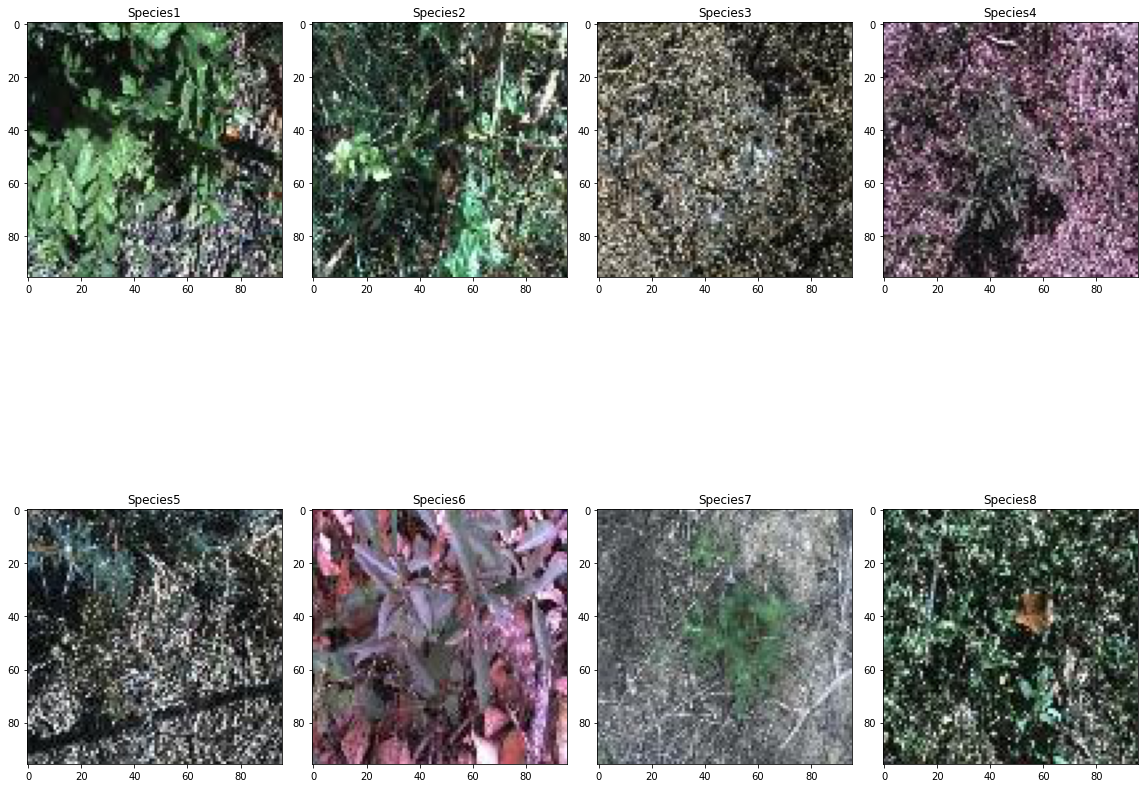

In [ ]:
#This snippet of code is used just to plot the images as an example, in order to inspect them    
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,4*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [ ]:
#DIRECTORY OF TRAINING AND VALIDATION SO THAT THE IMAGEDATAGENERATOR COULD GET IMAGES FROM RIGHT FOLDER
training_dir = "/content/data_splitted_final/train"
validation_dir = "/content/data_splitted_final/val"

parmeters that have to be changed everytime according to model structure

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
#HERE THE DATA AUGMENTATION: ROTATION,SHIFT,SHEAR,BRIGHTENSS,ZOOM,NO NEED TO PREPROCESS BECAUSE B1 ALREADY DO IT INSIDE IT
aug_train_data_gen = ImageDataGenerator(rotation_range=35,
                                        height_shift_range=0.23,
                                        width_shift_range=0.23,
                                        zoom_range=0.25,
                                        brightness_range = (0.8,1.2),
                                        shear_range = 0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        ) 

valid_data_gen = ImageDataGenerator()


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size= (240,240),
                                                           color_mode='rgb',
                                                           classes=None, 
                                                           class_mode='categorical',
                                                           batch_size=16,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size= (240,240),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


# LEARN

### MODEL METADATA

In [ ]:
#INPUT SHAPE OF THE EFFICIENTNETB1
input_shape = (240, 240, 3)
epochs = 50

### CNN MODEL

In [ ]:
#DOWNLOAD THE PRETRAINED EFFICIENTNETB1. SET ALL LAYERS TO NON TRAINABLE
efficient_netb1 = tf.keras.applications.EfficientNetB1(weights='imagenet', include_top=False, input_shape= input_shape)
for layer in efficient_netb1.layers:
  layer.trainable = False
efficient_netb1.summary()

KeyboardInterrupt: ignored

Other type of data agumentation that is not present in flowfromdirectory

In [ ]:
#THE ACTUAL MODEL: INPUT + EFFICIENTNETB1 + GLOBALAVERAGEPOOLING2D + DENSE LAYERS
inputs = tfk.Input(shape= (240,240,3))

x1 = efficient_netb1(inputs)
x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x1)
x = tfkl.Dropout(0.5, name="dropout1")(x)

outputs = tfkl.Dense(
    8, 
    activation='softmax'
    )(x)


efficientb1 = tfk.Model(inputs=inputs, outputs=outputs, name='model')



In [ ]:
# Compile the model
efficientb1 = tfk.Model(inputs=inputs, outputs=outputs, name='model')
efficientb1.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.001), metrics='accuracy')
efficientb1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 dropout1 (Dropout)          (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 6,585,487
Trainable params: 10,248
Non-trainable params: 6,575,239
______________________________________________

to balance the class weights


In [ ]:
#CLASS WEIGHTS SINCE NOT ALL CLASSES HAVE THE SAME AMOUNT OF DATA. TO GIVE MORE IMPORTANCE TO THE CLASSES WITH LESS SAMPLES
class_weights = {0: 1. ,1: 2.86 ,2: 2.77 ,3: 2.75 ,4: 2.85 ,5: 1.19 ,6: 2.89 ,7: 2.73 }

In [ ]:
# Train the model
history = efficientb1.fit(
    x = aug_train_gen,
    epochs = 100,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
    class_weight= class_weights
).history

Epoch 1/100
177/177 [==============================] - 71s 318ms/step - loss: 4.1778 - accuracy: 0.3613 - val_loss: 1.4650 - val_accuracy: 0.4881
Epoch 2/100
177/177 [==============================] - 47s 264ms/step - loss: 3.3158 - accuracy: 0.4973 - val_loss: 1.2968 - val_accuracy: 0.5540
Epoch 3/100
177/177 [==============================] - 47s 267ms/step - loss: 3.0415 - accuracy: 0.5528 - val_loss: 1.2336 - val_accuracy: 0.5540
Epoch 4/100
177/177 [==============================] - 45s 257ms/step - loss: 2.8717 - accuracy: 0.5769 - val_loss: 1.2192 - val_accuracy: 0.5610
Epoch 5/100
177/177 [==============================] - 45s 254ms/step - loss: 2.8172 - accuracy: 0.5765 - val_loss: 1.1527 - val_accuracy: 0.5989
Epoch 6/100
177/177 [==============================] - 45s 257ms/step - loss: 2.7077 - accuracy: 0.6027 - val_loss: 1.1426 - val_accuracy: 0.5933
Epoch 7/100
177/177 [==============================] - 45s 253ms/step - loss: 2.6476 - accuracy: 0.6048 - val_loss: 1.1234 -

### Plot the training

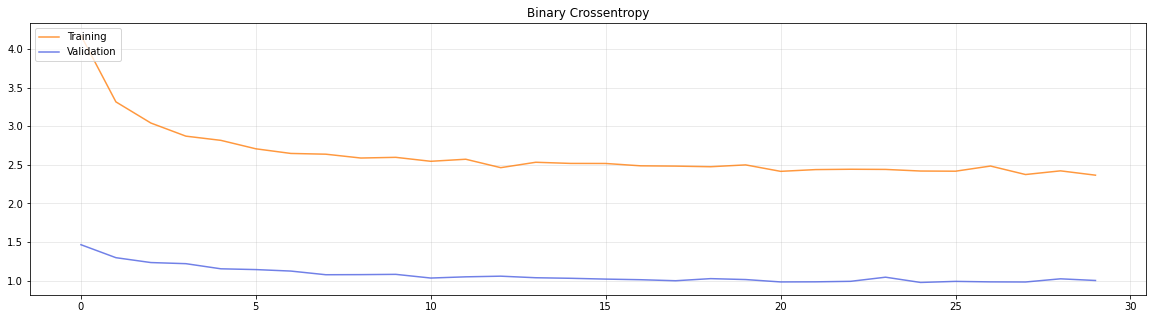

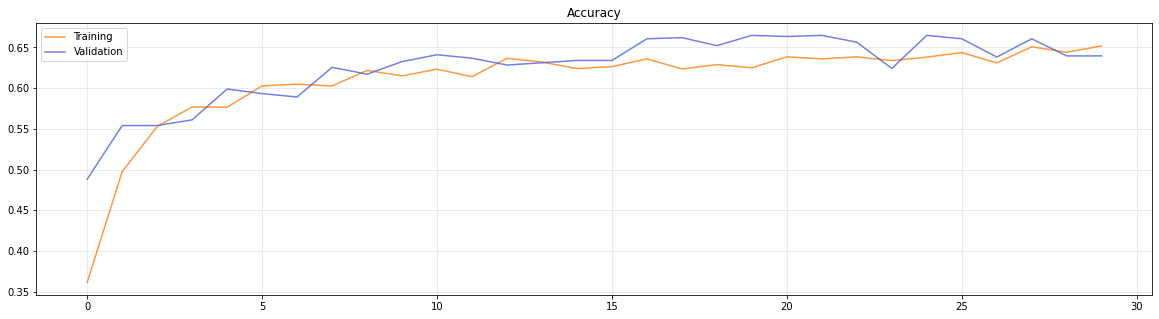

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Show Statistics

### Save Model

In [ ]:
#MOUNT DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#SAVE TL MODEL
efficientb1.save('/content/efficientnetB1')

In [ ]:
%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS

/content/drive/MyDrive/FINAL


### Fine Tuning

In [ ]:
#LOAD THE TL MODEL
ft_model = tfk.models.load_model('/content/efficientnetB1')

In [ ]:
#load from drive
#%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS
#ft_model = tfk.models.load_model('efficientnetB1')

In [ ]:
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 dropout1 (Dropout)          (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 6,585,487
Trainable params: 10,248
Non-trainable params: 6,575,239
______________________________________________

In [ ]:
# Set all EFFICIENTNETB1 layers to True
ft_model.get_layer('efficientnetb1').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetb1').layers):
   print(i, layer.name, layer.trainable)

ft_model.summary()

0 input_1 True
1 rescaling True
2 normalization True
3 tf.math.truediv True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True
41 bl

In [ ]:
#IN THIS CASE WE DO NOT FREEZE ANY LAYER BUT WE RETRAINED EVERYTHING BECAUSE MODEL IS NOT SO COMPLEX
for i, layer in enumerate(ft_model.get_layer('efficientnetb1').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 True
1 rescaling True
2 normalization True
3 tf.math.truediv True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True
41 bl

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')


Already did 100 epochs

In [ ]:
history = ft_model.fit(
    x = aug_train_gen,
    epochs = 50,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)],
    class_weight= class_weights
).history

Epoch 1/50
177/177 [==============================] - 98s 426ms/step - loss: 3.6339 - accuracy: 0.4800 - val_loss: 1.2479 - val_accuracy: 0.5526
Epoch 2/50
177/177 [==============================] - 68s 384ms/step - loss: 2.5614 - accuracy: 0.6200 - val_loss: 1.0527 - val_accuracy: 0.6353
Epoch 3/50
177/177 [==============================] - 67s 377ms/step - loss: 1.9684 - accuracy: 0.7041 - val_loss: 0.9889 - val_accuracy: 0.6424
Epoch 4/50
177/177 [==============================] - 64s 362ms/step - loss: 1.7509 - accuracy: 0.7324 - val_loss: 0.9395 - val_accuracy: 0.6985
Epoch 5/50
177/177 [==============================] - 61s 341ms/step - loss: 1.5762 - accuracy: 0.7600 - val_loss: 0.8136 - val_accuracy: 0.7279
Epoch 6/50
177/177 [==============================] - 60s 337ms/step - loss: 1.4182 - accuracy: 0.7851 - val_loss: 0.7176 - val_accuracy: 0.7475
Epoch 7/50
177/177 [==============================] - 60s 338ms/step - loss: 1.2632 - accuracy: 0.8066 - val_loss: 0.6560 - val_ac

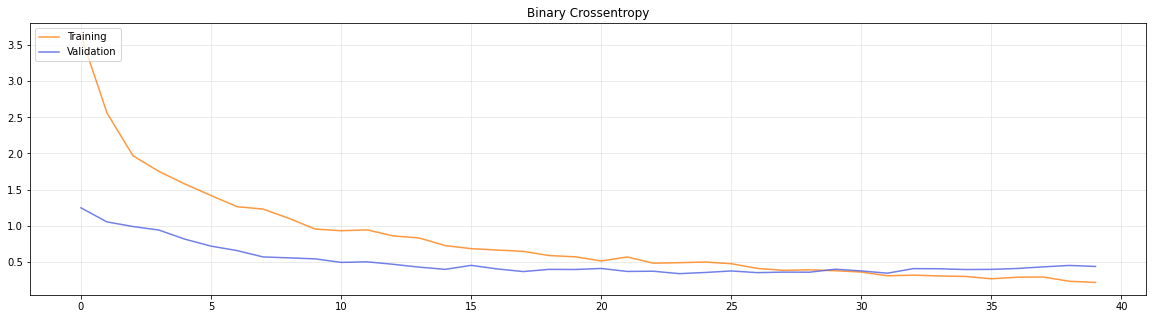

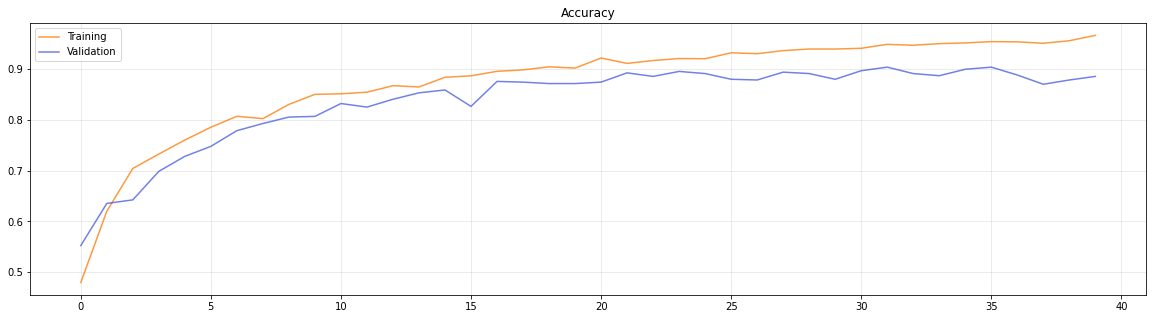

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
ft_model.save('/content/efficientnetB1')

In [ ]:
#save on drive
#%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS
#ft_model.save('efficientnetB1')

# EfficientNetB2

# PREPROCESSING

### IMPORT




In [ ]:
#import of all necessary libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.layers.experimental import preprocessing


tfk = tf.keras
tfkl = tf.keras.layers


# set the Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#REMOVE ALL WARNINGS
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### READ IMAGES AND SET LABELS

In [ ]:
#UNZIP THE ALREADY CREATED FOLDER
#!unzip "/content/data_splitted_final.zip" -d "/content"

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/data_splitted_final/train/Species6/00146.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00146.jpg  
  inflating: /content/data_splitted_final/train/Species6/00152.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00152.jpg  
  inflating: /content/data_splitted_final/train/Species6/00185.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00185.jpg  
  inflating: /content/data_splitted_final/train/Species6/00191.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00191.jpg  
  inflating: /content/data_splitted_final/train/Species6/00032.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00032.jpg  
  inflating: /content/data_splitted_final/train/Species6/00027.jpg  
  inflating: /content/__MACOSX/data_splitted_final/train/Species6/._00027.jpg  
  inflating: /content/data_splitted_final/train/Species6

In [ ]:
os.chdir("/content/data_splitted_final")

In [ ]:
#CHECK PRESENCE OF THE TWO FOLDERS
!ls

train  val


In [ ]:
dataset_dir = "/content/data_splitted_final"

In [ ]:
#Write the labels, they need to the same as the name of the folders
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8'] #7

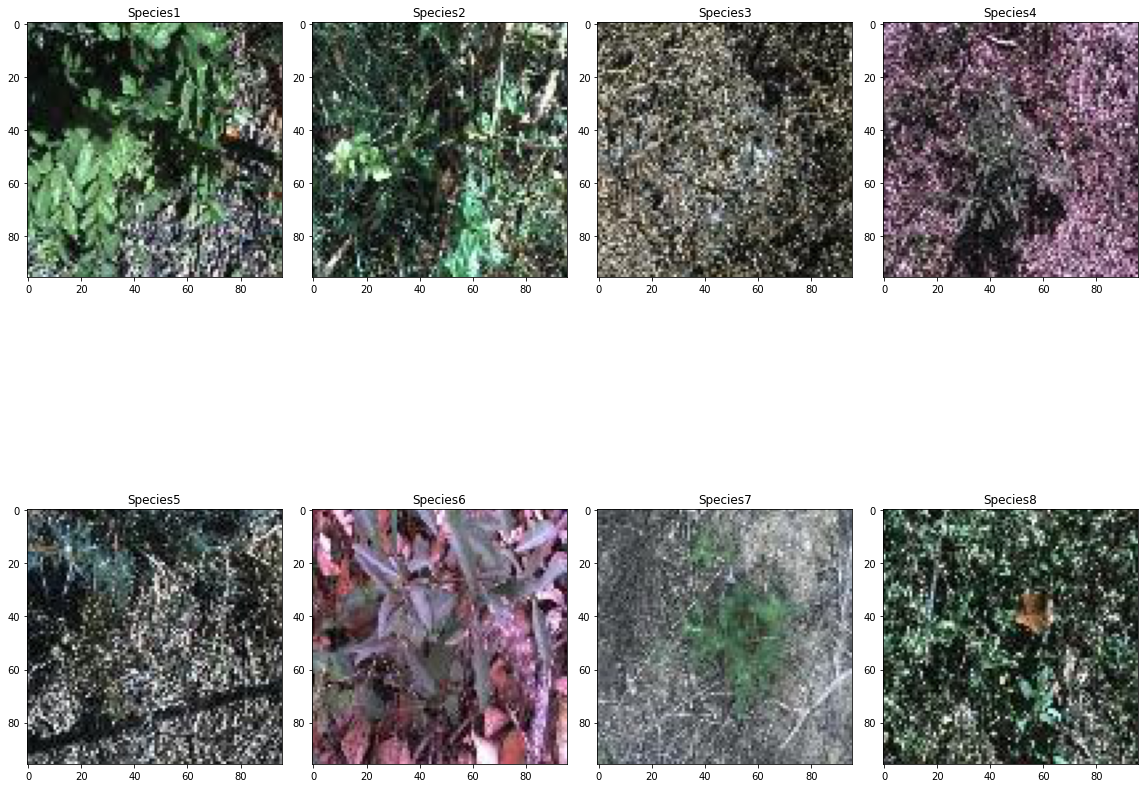

In [ ]:
#This snippet of code is used just to plot the images as an example, in order to inspect them    
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,4*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [ ]:
#PATH TO GET TRAIN AND VAL FOLDERS
training_dir = "/content/data_splitted_final/train"
validation_dir = "/content/data_splitted_final/val"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#DID SOME AUGMENTATION: ROTATION,BRIGHTENSS, SHEAR, FLIP, SHIFTS, NO NEED TO DO ANY PREPROCESSING
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=35,
                                        height_shift_range=0.25,
                                        width_shift_range=0.25,
                                        zoom_range=0.25,
                                        brightness_range = (0.75,1.25),
                                        shear_range = 0.15,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        ) 

valid_data_gen = ImageDataGenerator()


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size= (260,260),
                                                           color_mode='rgb',
                                                           classes=None, 
                                                           class_mode='categorical',
                                                           batch_size=16,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size= (260,260),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


# LEARN

### MODEL METADATA

In [ ]:
#B2 REQUIRES 260,260 IMAGES AS INPUT
input_shape = (260, 260, 3)
epochs = 45

### CNN MODEL

In [ ]:
#DOWNLOADING B2 WITH WEIGHTS TRAINED ON IMAGENET AND MAKE ALL LAYERS NOT TRAINABLE
efficient_netb2 = tf.keras.applications.EfficientNetB2(weights='imagenet', include_top=False, input_shape= input_shape)
for layer in efficient_netb2.layers:
  layer.trainable = False
efficient_netb2.summary()

31790344/31790344 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 260, 260, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 260, 260, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TF

In [ ]:
#OUR MODEL: IMPUT + EFFICIENTNETB2 + GLOBALPOOLING + DROPOUT (VERY HIGH RATE) + OUTPUT LAYER
inputs = tfk.Input(shape= (260,260,3))

x1 = efficient_netb2(inputs)

x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x1)
    
x = tfkl.Dropout(0.55, name="dropout1")(x)

outputs = tfkl.Dense(
    8, 
    activation='softmax'
    )(x)


efficientb2 = tfk.Model(inputs=inputs, outputs=outputs, name='model')



In [ ]:
# Compile the model. FIRST LR IS VERY LOW
efficientb2 = tfk.Model(inputs=inputs, outputs=outputs, name='model')
efficientb2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.01), metrics='accuracy')
efficientb2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1408)             0         
 ing2D)                                                          
                                                                 
 dropout1 (Dropout)          (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 8)                 11272     
                                                                 
Total params: 7,779,841
Trainable params: 11,272
Non-trainable params: 7,768,569
______________________________________________

to balance the class weights


In [ ]:
#TO GIVE MORE IMPORTANCE TO THE SAMPLES FROM LESS REPRESENTED CLASSES
class_weights = {0: 1. ,1: 2.86 ,2: 2.77 ,3: 2.75 ,4: 2.85 ,5: 1.19 ,6: 2.89 ,7: 2.73 }

In [ ]:
efficientb2.get_layer('efficientnetb2').trainable = False
for i, layer in enumerate(efficientb2.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)

efficientb2.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

In [ ]:
# Train the model
history = efficientb2.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)],
    class_weight= class_weights
).history

Epoch 1/45
177/177 [==============================] - 94s 420ms/step - loss: 4.1198 - accuracy: 0.4507 - val_loss: 1.6499 - val_accuracy: 0.4937
Epoch 2/45
177/177 [==============================] - 56s 318ms/step - loss: 3.8806 - accuracy: 0.5104 - val_loss: 1.3808 - val_accuracy: 0.5231
Epoch 3/45
177/177 [==============================] - 54s 306ms/step - loss: 4.2931 - accuracy: 0.5062 - val_loss: 1.5011 - val_accuracy: 0.4951
Epoch 4/45
177/177 [==============================] - 53s 301ms/step - loss: 4.2580 - accuracy: 0.5313 - val_loss: 1.9275 - val_accuracy: 0.4334
Epoch 5/45
177/177 [==============================] - 53s 302ms/step - loss: 4.1072 - accuracy: 0.5387 - val_loss: 1.3343 - val_accuracy: 0.5442
Epoch 6/45
177/177 [==============================] - 54s 304ms/step - loss: 4.2822 - accuracy: 0.5429 - val_loss: 1.5187 - val_accuracy: 0.5147
Epoch 7/45
177/177 [==============================] - 53s 298ms/step - loss: 4.5141 - accuracy: 0.5235 - val_loss: 1.7964 - val_ac

### Plot the training

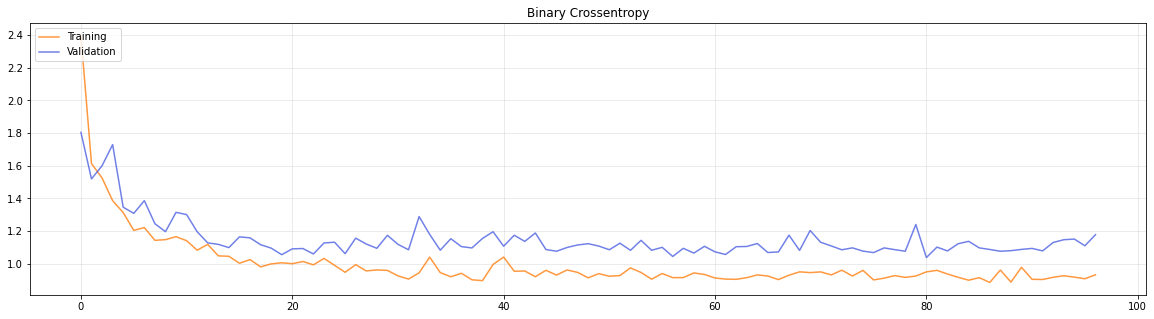

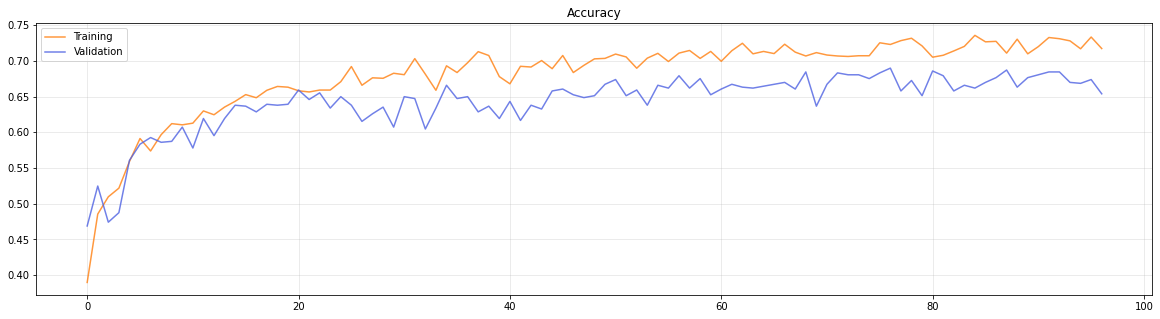

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Show Statistics

### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
efficientb2.save('/content/efficientnetB2')

In [ ]:
%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS

/content/drive/MyDrive/FINAL


In [ ]:
#SAVE ON drive

#ft_model.save('efficientnetB2')

### Fine Tuning

In [ ]:
#LOAD THE SAVED MODEL
ft_model = tfk.models.load_model('/content/efficientnetB2')

In [ ]:
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1408)             0         
 ing2D)                                                          
                                                                 
 dropout1 (Dropout)          (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 8)                 11272     
                                                                 
Total params: 7,779,841
Trainable params: 11,272
Non-trainable params: 7,768,569
______________________________________________

In [ ]:
# Set all B2 layers to TRAINABLE
ft_model.get_layer('efficientnetb2').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)

ft_model.summary()

0 input_1 True
1 rescaling True
2 normalization True
3 tf.math.truediv True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True
41 bl

In [ ]:
#FREEZE ONLY FIRST 40 LAYERS
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers[:40]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

In [ ]:
#LOW LEARNING RATE
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')


In [ ]:
history = ft_model.fit(
    x = aug_train_gen,
    epochs = 50,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)],
    class_weight= class_weights
).history

Epoch 1/50
177/177 [==============================] - 80s 371ms/step - loss: 6.9827 - accuracy: 0.4019 - val_loss: 1.5490 - val_accuracy: 0.5035
Epoch 2/50
177/177 [==============================] - 64s 359ms/step - loss: 4.3292 - accuracy: 0.5313 - val_loss: 1.3744 - val_accuracy: 0.5806
Epoch 3/50
177/177 [==============================] - 65s 366ms/step - loss: 3.3048 - accuracy: 0.5924 - val_loss: 1.1685 - val_accuracy: 0.6297
Epoch 4/50
177/177 [==============================] - 64s 360ms/step - loss: 2.9317 - accuracy: 0.6260 - val_loss: 1.0895 - val_accuracy: 0.6396
Epoch 5/50
177/177 [==============================] - 64s 360ms/step - loss: 2.4555 - accuracy: 0.6783 - val_loss: 0.9948 - val_accuracy: 0.6774
Epoch 6/50
177/177 [==============================] - 65s 366ms/step - loss: 2.2509 - accuracy: 0.7055 - val_loss: 0.8920 - val_accuracy: 0.7209
Epoch 7/50
177/177 [==============================] - 64s 361ms/step - loss: 2.1010 - accuracy: 0.7225 - val_loss: 0.8442 - val_ac

In [ ]:
ft_model.save('/content/efficientnetB2')

In [ ]:
#save on drive
#%cd /content/drive/MyDrive/ARTIFICIAL_NEURAL_NOOBS
#ft_model.save('efficientnetB2')

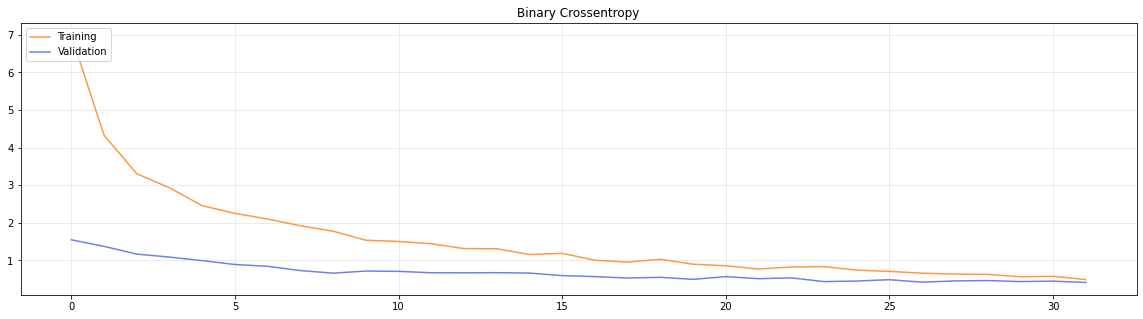

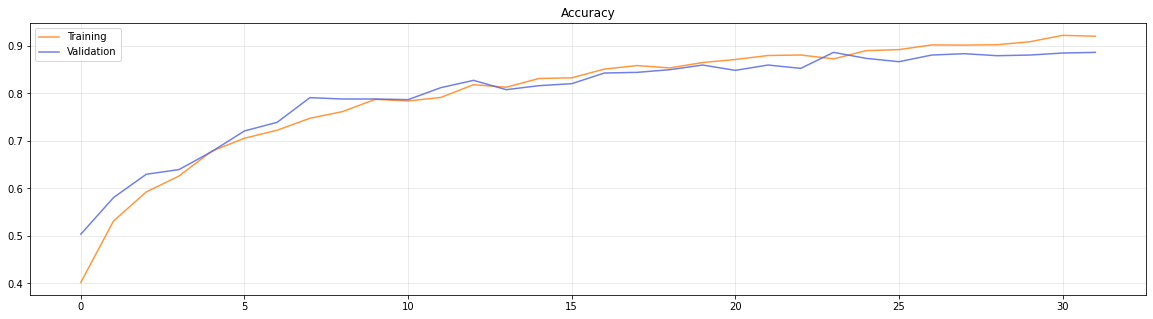

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#Ensemble

In [1]:
class model:
    
    def __init__(self,path):
        self.model1 = tf.keras.models.load_model('/content/xception')
        self.model2 = tf.keras.models.load_model('/content/vgg19')
        self.model3 = tf.keras.models.load_model('/content/efficientnetB1')
        self.model4 = tf.keras.models.load_model('/content/efficientnetB2')
        self.model5 = tf.keras.models.load_model('/content/resnet50')

    def predict(self, X):

        
        
        X1 = X 
        X2= X
        X4= tf.image.resize(X,[260,260])
        X5= X

        
        
        X1= tf.keras.applications.xception.preprocess_input(X1)
        X2= tf.keras.applications.vgg19.preprocess_input(X2)

        X3 = tf.image.resize(X, [240,240])

        X5 = tf.keras.applications.resnet_v2.preprocess_input(X5)
 

        out1 = self.model1.predict(X1)
        out2 = self.model2.predict(X2)
        out3= self.model3.predict(X3)
        out4= self.model4.predict(X4)
        out5= self.model5.predict(X5)


        out1 = tf.math.scalar_mul(0.2,out1)
        out2 = tf.math.scalar_mul(0.2,out2)
        out3 = tf.math.scalar_mul(0.4,out3)
        out4 = tf.math.scalar_mul(0.2,out4)
        out5 = tf.math.scalar_mul(0.2,out5)


        out_ensemble1 = tf.add(out1,out2)
        out_ensemble2 = tf.add(out4,out3)
        out_ensemble3 = tf.add(out_ensemble1,out_ensemble2)
        out_ensemble= tf.add(out5, out_ensemble3)
        out = tf.argmax(out_ensemble, axis=-1)

        return out